Running with initialization: observed


100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


Running with initialization: transpose


100%|██████████| 100/100 [01:01<00:00,  1.61it/s]


Running with initialization: clean


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Running with initialization: zeros


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


Running with initialization: ones


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


Running with initialization: normal_random


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Running with initialization: uniform_random


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


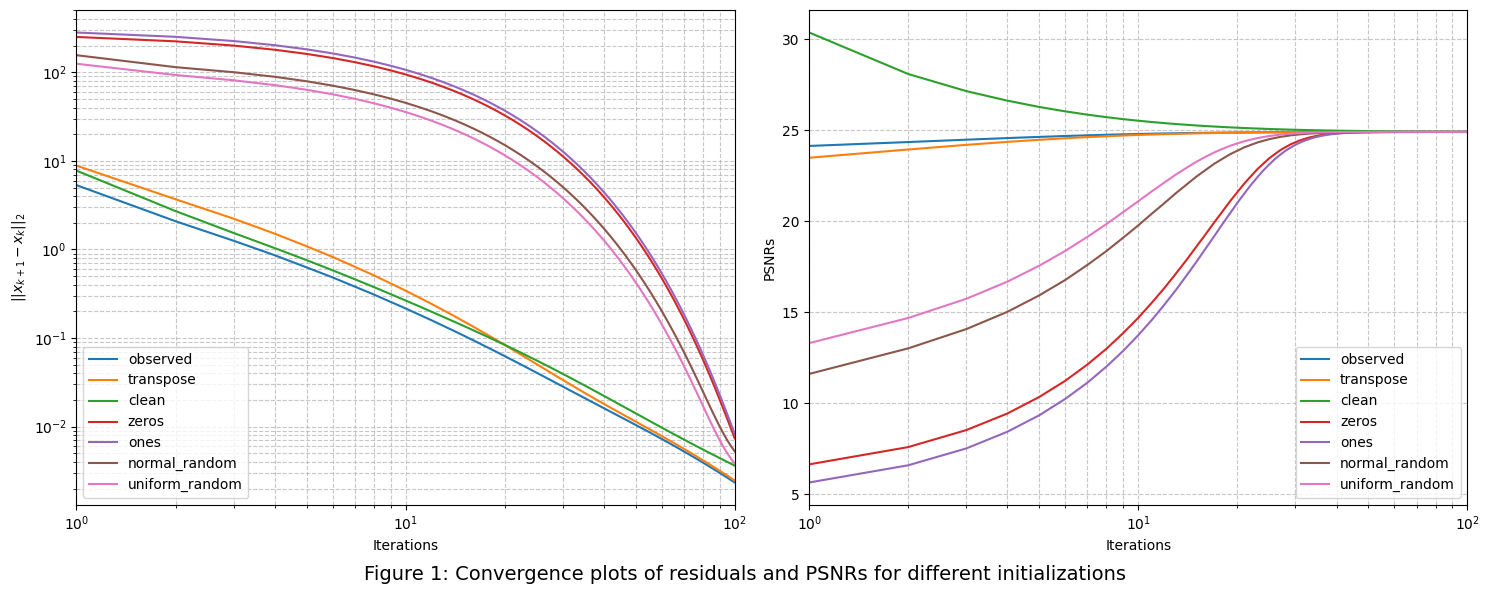

<Figure size 640x480 with 0 Axes>

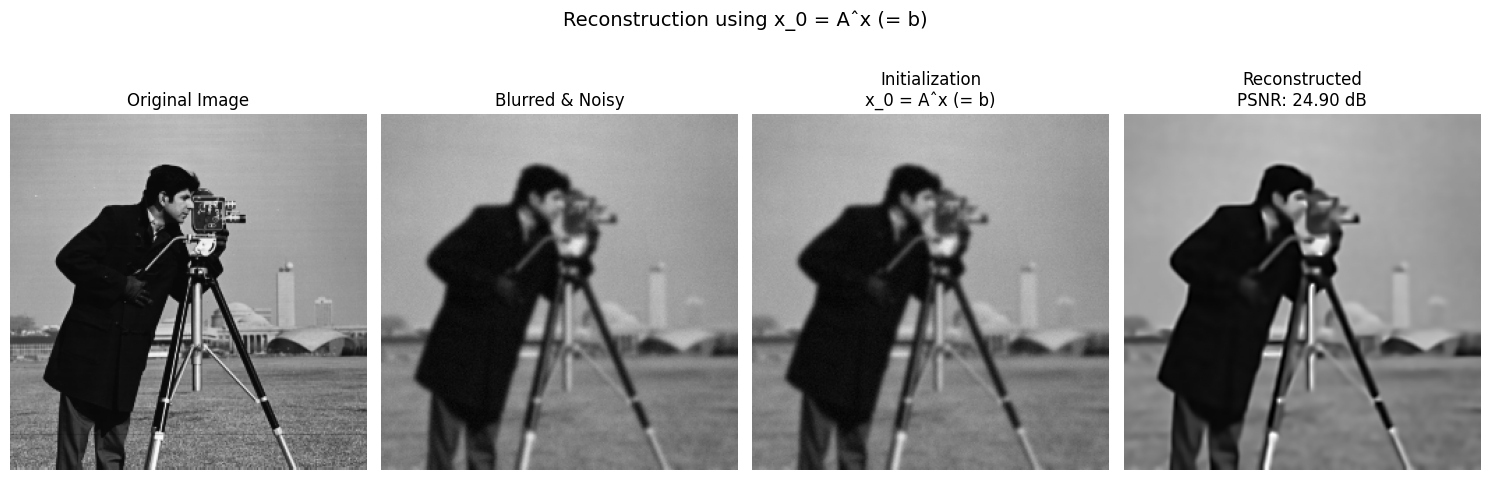

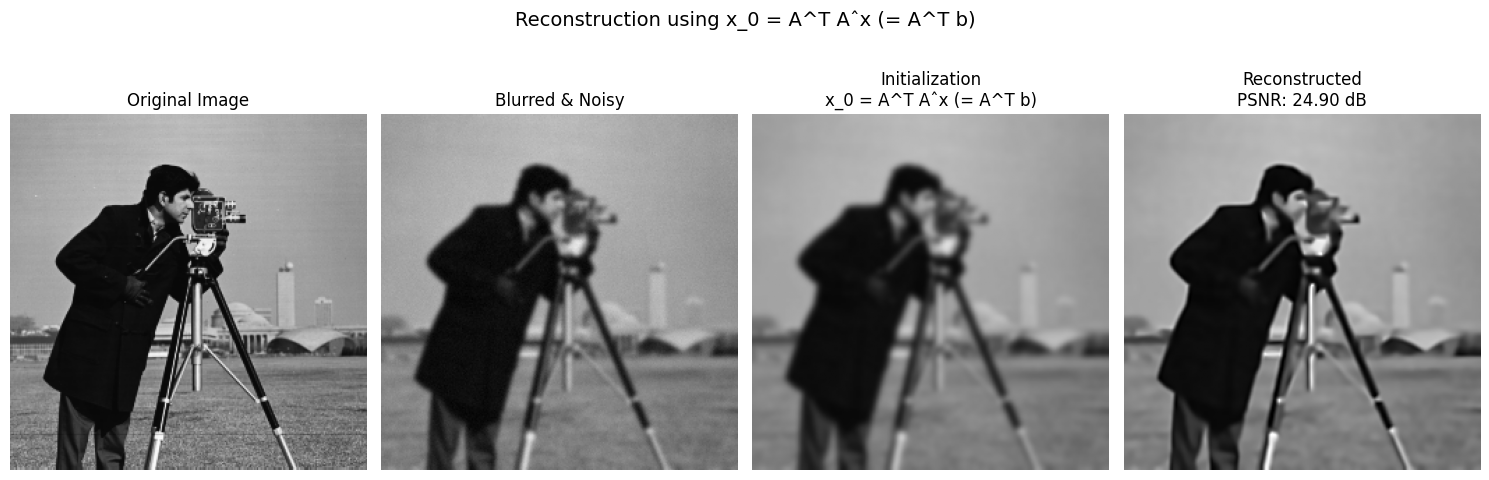

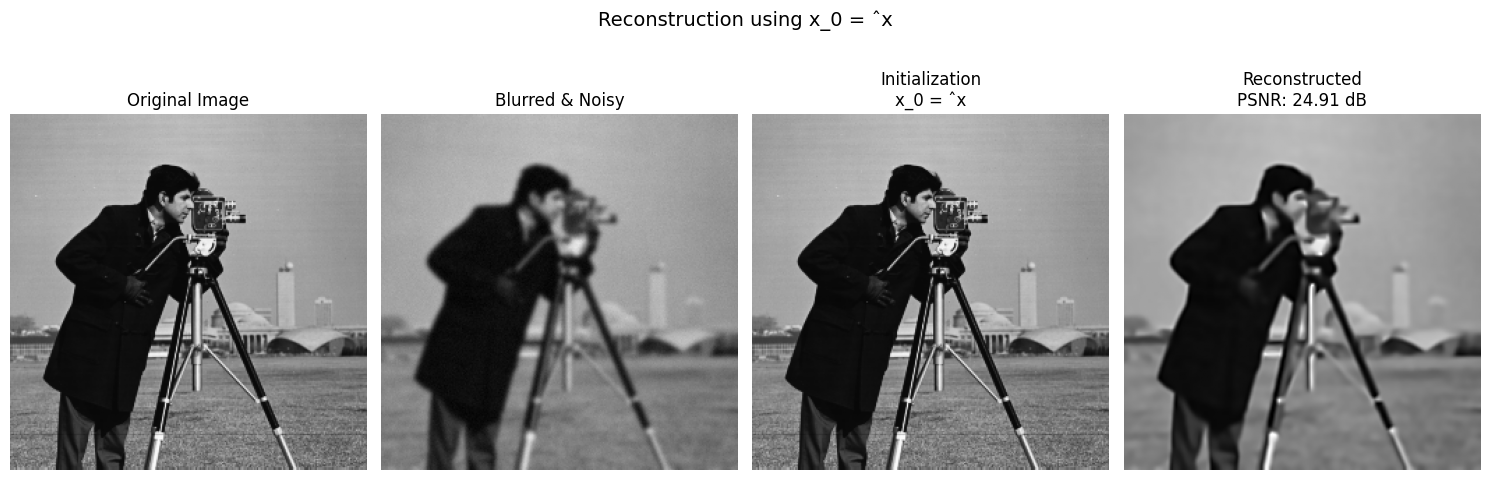

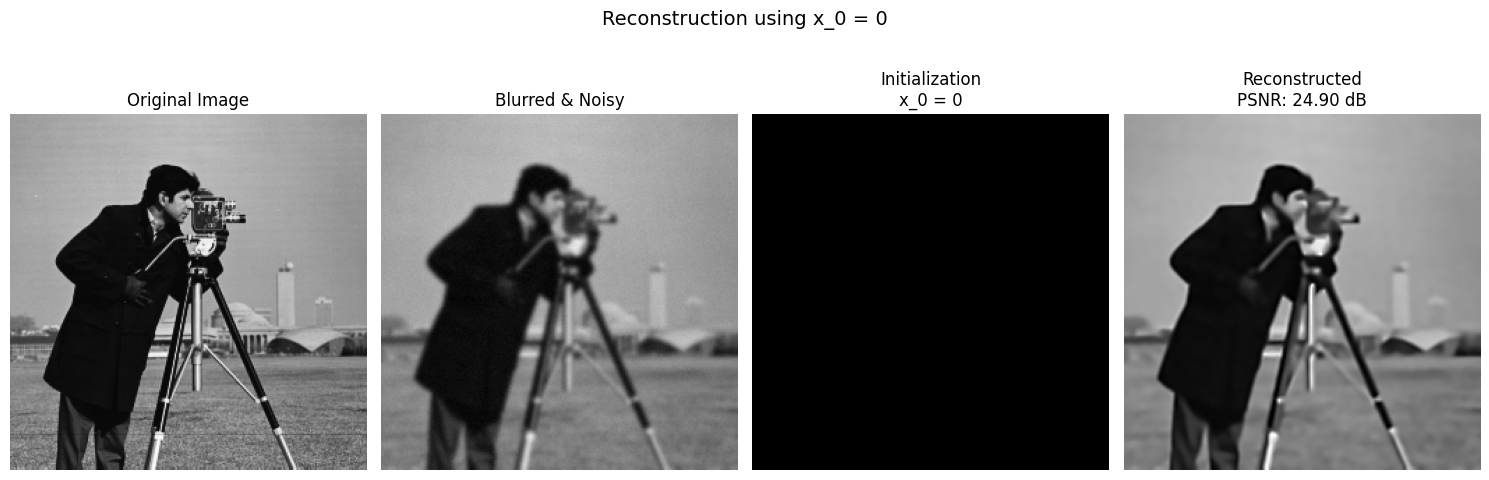

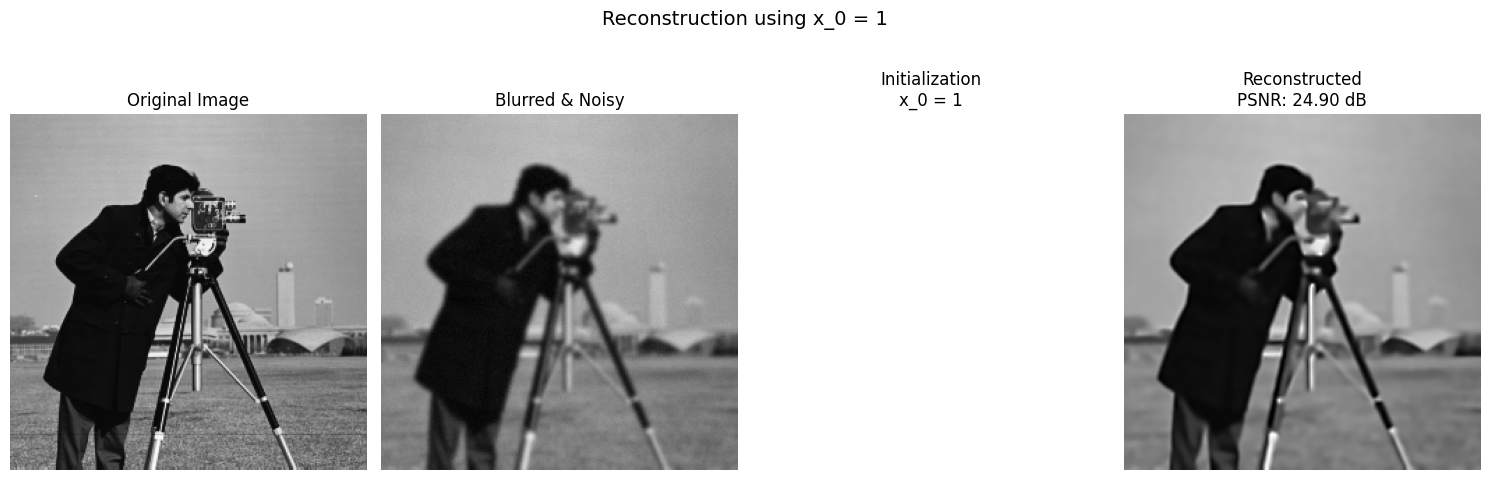

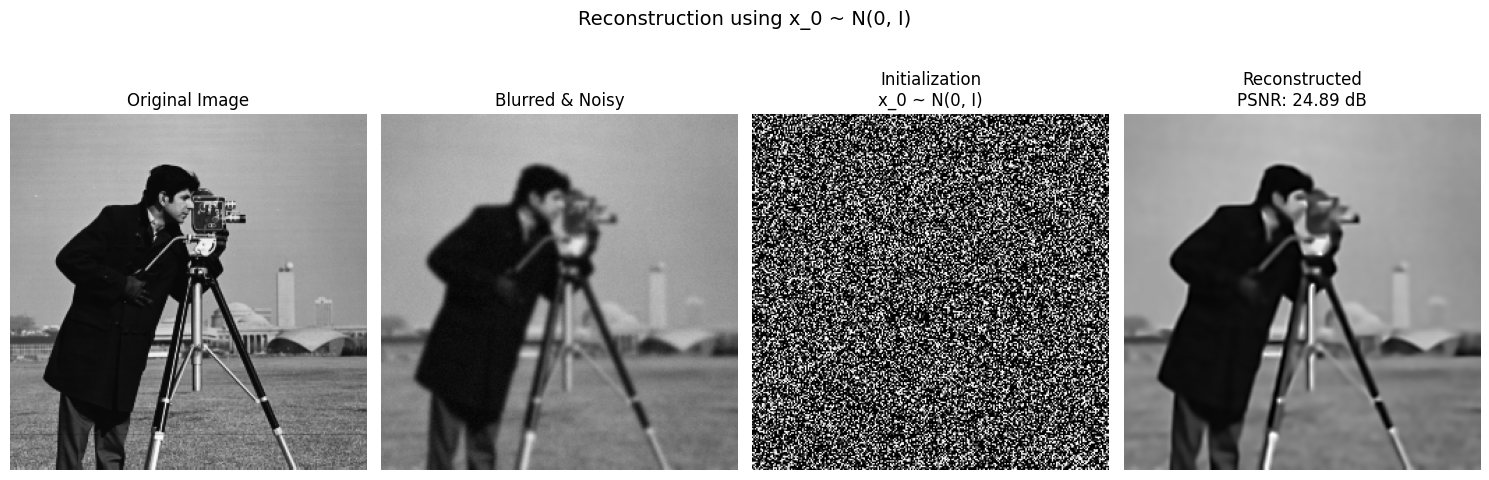

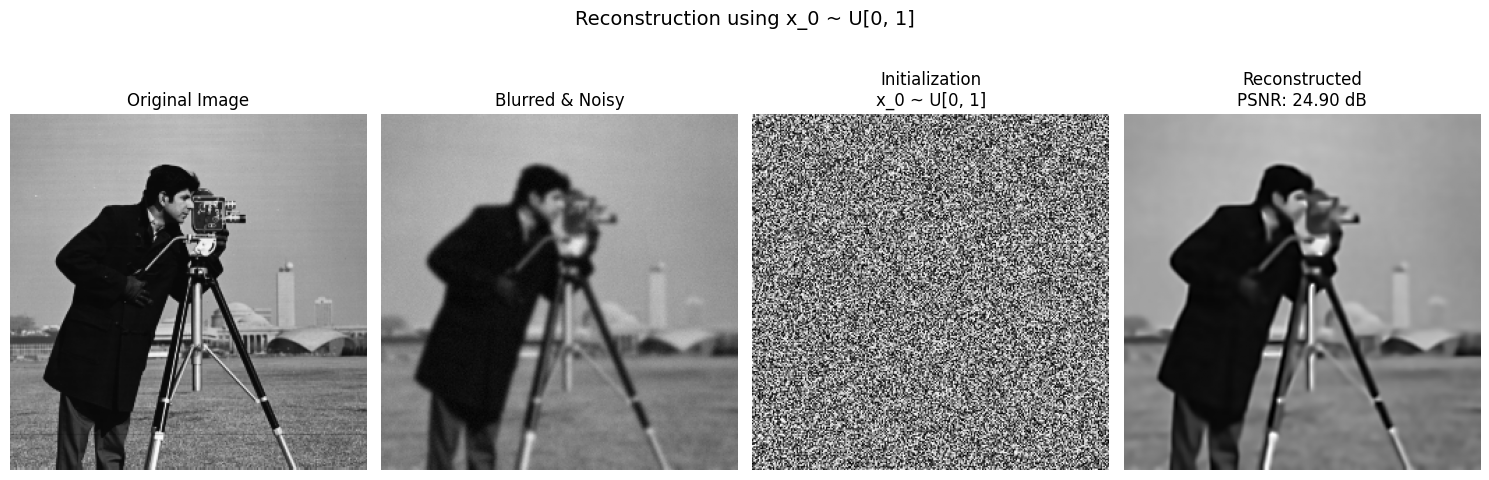

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import io, color, metrics
import os
from tqdm import tqdm


def gaussian_kernel(size, sigma):
    """
    Creates a 2D Gaussian kernel with specified size and sigma
    """
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()


def blur_image(image, kernel):
    """
    Apply blur using a convolution kernel
    """
    if len(image.shape) == 3:
        blurred = np.zeros_like(image)
        for i in range(image.shape[2]):
            blurred[:,:,i] = ndimage.convolve(image[:,:,i], kernel, mode='reflect')
        return blurred
    else:
        return ndimage.convolve(image, kernel, mode='reflect')


def add_gaussian_noise(image, sigma):
    """
    Add Gaussian noise to an image
    """
    noise = np.random.normal(0, sigma, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)


def gradient_descent_step(x, A, AT, b, gamma):

    Ax = A(x)
    residual = Ax - b
    gradient = AT(residual)
    return x - gamma * gradient


def A_operator(x, kernel):

    return blur_image(x, kernel)


def AT_operator(x, kernel):

    return blur_image(x, kernel)


def calculate_psnr(original, reconstructed):

    return metrics.peak_signal_noise_ratio(original, reconstructed, data_range=1.0)


def calculate_residual(x, prev_x):

    return np.linalg.norm(x - prev_x) / np.linalg.norm(x)



def integral_img_sq_diff(v, dx, dy):
    t = img2Dshift(v, dx, dy)
    diff = (v-t)**2
    diff = diff.astype(np.float64)
    sd = np.cumsum(diff, axis=0)
    sd = np.cumsum(sd, axis=1)
    return(sd, diff, t)


def triangle(dx, dy, Ns):
    r1 = max(1 - (abs(dx)/(Ns+1)), 0)
    r2 = max(1 - (abs(dy)/(Ns+1)), 0)
    return r1*r2


def img2Dshift(v, dx, dy):
    row, col = v.shape
    t = np.zeros((row, col))
    typ = (1 if dx>0 else 0)*2 + (1 if dy>0 else 0)
    if(typ==0):
        t[-dx:, -dy:] = v[0:row+dx, 0:col+dy]
    elif(typ==1):
        t[-dx:, 0:col-dy] = v[0:row+dx, dy:]
    elif(typ==2):
        t[0:row-dx, -dy:] = v[dx:, 0:col+dy]
    elif(typ==3):
        t[0:row-dx, 0:col-dy] = v[dx:, dy:]
    return t


def seperable_trainagle(dx, dy, Ns, height, width):
    value = max(0, 1 - (abs(dx)/(Ns+1))) * max(0, 1 - (abs(dy)/(Ns+1)))
    Hat = np.full((height, width), value).astype(np.float64)

    if dx >= 0:
        Hat[height-dx:, :] = 0
    else:
        Hat[:abs(dx), :] = 0

    if dy >= 0:
        Hat[:, width-dy:] = 0
    else:
        Hat[:, :abs(dy)] = 0

    return Hat.astype(np.float64)


def DSG_NLM(input_image, guide_image, patch_rad, window_rad, sigma):
    """
    DSG-NLM algorithm as provided
    """
    input_image = input_image.astype(np.float64)
    guide_image = guide_image.astype(np.float64)

    if(len(input_image.shape) > 2):
        raise ValueError('Input must be a 2D array')
    height, width = input_image.shape
    u = np.zeros((height, width)).astype(np.float64)

    padded_guide = np.pad(guide_image, patch_rad, mode='symmetric').astype(np.float64)
    padded_v = np.pad(input_image, window_rad, mode='symmetric').astype(np.float64)
    normalization_factor = (sigma*sigma)
    normalization_factor = np.float64(normalization_factor)

    # 0th loop
    W0 = np.zeros((height, width)).astype(np.float64)
    for dx in np.arange(-window_rad, window_rad+1):
        for dy in np.arange(-window_rad, window_rad+1):
            sd, diff, t = integral_img_sq_diff(padded_guide, dx, dy)
            hat = seperable_trainagle(dx, dy, window_rad, height, width)
            temp1 = img2Dshift(sd, patch_rad, patch_rad)
            temp2 = img2Dshift(sd, -patch_rad-1, -patch_rad-1)
            temp3 = img2Dshift(sd, -patch_rad-1, patch_rad)
            temp4 = img2Dshift(sd, patch_rad, -patch_rad-1)
            res = temp1 + temp2 - temp3 - temp4
            sqdist1 = res[patch_rad:patch_rad+height, patch_rad:patch_rad+width]
            w = hat * np.exp(-sqdist1/normalization_factor).astype(np.float64)
            W0 = W0 + w

    # 1st loop
    W1 = np.zeros((height, width)).astype(np.float64)
    for dx in np.arange(-window_rad, window_rad+1):
        for dy in np.arange(-window_rad, window_rad+1):
            sd, diff, t = integral_img_sq_diff(padded_guide, dx, dy)
            hat = seperable_trainagle(dx, dy, window_rad, height, width)
            temp1 = img2Dshift(sd, patch_rad, patch_rad)
            temp2 = img2Dshift(sd, -patch_rad-1, -patch_rad-1)
            temp3 = img2Dshift(sd, -patch_rad-1, patch_rad)
            temp4 = img2Dshift(sd, patch_rad, -patch_rad-1)
            res = temp1 + temp2 - temp3 - temp4
            sqdist1 = res[patch_rad:patch_rad+height, patch_rad:patch_rad+width]
            w = hat * np.exp(-sqdist1/normalization_factor).astype(np.float64)
            W0_pad = np.pad(W0, window_rad, mode='symmetric')
            W0_shift = img2Dshift(W0_pad, dx, dy)
            W0_temp = W0_shift[window_rad:window_rad+height, window_rad:window_rad+width]
            w1 = w / (np.sqrt(W0)*np.sqrt(W0_temp)).astype(np.float64)
            W1 = W1 + w1

    # 2nd loop
    alpha = 1/np.max(W1).astype(np.float64)
    W2 = np.zeros((height, width)).astype(np.float64)
    for dx in np.arange(-window_rad, window_rad+1):
        for dy in np.arange(-window_rad, window_rad+1):
            if((dx != 0) or (dy != 0)):
                sd, diff, t = integral_img_sq_diff(padded_guide, dx, dy)
                hat = seperable_trainagle(dx, dy, window_rad, height, width)
                temp1 = img2Dshift(sd, patch_rad, patch_rad)
                temp2 = img2Dshift(sd, -patch_rad-1, -patch_rad-1)
                temp3 = img2Dshift(sd, -patch_rad-1, patch_rad)
                temp4 = img2Dshift(sd, patch_rad, -patch_rad-1)
                res = temp1 + temp2 - temp3 - temp4
                sqdist1 = res[patch_rad:patch_rad+height, patch_rad:patch_rad+width]
                w = hat * np.exp(-sqdist1/normalization_factor).astype(np.float64)
                W0_pad = np.pad(W0, window_rad, mode='symmetric')
                W0_shift = img2Dshift(W0_pad, dx, dy)
                W0_temp = W0_shift[window_rad:window_rad+height, window_rad:window_rad+width]
                w2 = (alpha*w) / (np.sqrt(W0)*np.sqrt(W0_temp)).astype(np.float64)
                v = padded_v[window_rad+dx:window_rad+dx+height, window_rad+dy:window_rad+dy+width]
                u = u + w2*v
                W2 = W2 + w2

    u = u + (1-W2)*input_image
    u = u.astype(np.float64)
    return u


def NLM_denoiser(img, observed_img, patch_rad=3, window_rad=10, sigma=0.02):
    """
    Wrapper for DSG_NLM to use as the denoiser in PnP-PGD
    Now using observed_img as guide image
    """
    if len(img.shape) == 3:
        output = np.zeros_like(img)
        for i in range(img.shape[2]):
            output[:,:,i] = DSG_NLM(img[:,:,i], observed_img[:,:,i], patch_rad, window_rad, sigma)
        return output
    else:
        return DSG_NLM(img, observed_img, patch_rad, window_rad, sigma)


def pnp_pgd(A, AT, b, D, x0, gamma=1.9, max_iter=450, tol=1e-5, orig_img=None):

    x = x0.copy()
    residuals = []
    psnrs = []

    for i in tqdm(range(max_iter)):
        x_prev = x.copy()

        # Gradient descent step
        x_gd = gradient_descent_step(x, A, AT, b, gamma)

        x = D(x_gd, b)

        residual = np.linalg.norm(x - x_prev)
        residuals.append(residual)

        if orig_img is not None:
            psnr = calculate_psnr(orig_img, x)
            psnrs.append(psnr)

        if residual < tol:
            print(f"Converged after {i+1} iterations")
            break

    return x, residuals, psnrs


def main():
    img_path = "/content/cameraman.tif"
    try:
        orig_img = io.imread(img_path)
    except FileNotFoundError:
        print(f"Image {img_path} not found. Using a sample image.")
        orig_img = np.zeros((256, 256))
        orig_img[64:192, 64:192] = 1

    if len(orig_img.shape) == 3 and orig_img.shape[2] > 1:
        orig_img = color.rgb2gray(orig_img)

    if orig_img.max() > 1.0:
        orig_img = orig_img / 255.0

    sigma = 1.6
    radius = 12
    kernel_size = 2 * radius + 1
    kernel = gaussian_kernel(kernel_size, sigma)

    A = lambda x: A_operator(x, kernel)
    AT = lambda x: AT_operator(x, kernel)

    blurred_img = A(orig_img)
    noise_sigma = 0.01
    observed_img = add_gaussian_noise(blurred_img, noise_sigma)

    D = lambda x, guide: NLM_denoiser(x, guide, patch_rad=2, window_rad=3, sigma=0.2)

    init_methods = {
        "observed": observed_img,
        "transpose": AT(observed_img),
        "clean": orig_img,
        "zeros": np.zeros_like(orig_img),
        "ones": np.ones_like(orig_img),
        "normal_random": np.random.normal(0, 1, orig_img.shape),
        "uniform_random": np.random.uniform(0, 1, orig_img.shape)
    }

    results = {}

    for name, x0 in init_methods.items():
        print(f"Running with initialization: {name}")

        x0 = np.clip(x0, 0, 1)

        reconstructed, residuals, psnrs = pnp_pgd(A, AT, observed_img, D, x0, gamma=1.9, max_iter=100, orig_img=orig_img)

        results[name] = {
            "reconstructed": reconstructed,
            "residuals": residuals,
            "psnrs": psnrs,
            "initialization": x0
        }

    os.makedirs("results", exist_ok=True)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    for name, result in results.items():
        plt.loglog(range(1, len(result["residuals"])+1), result["residuals"], label=name)
    plt.xlabel("Iterations")
    plt.ylabel("$||x_{k+1} - x_k||_2$")
    plt.title("")
    plt.legend()
    plt.grid(True, which="both", linestyle='--', alpha=0.7)
    plt.xlim(1, 100)

    plt.subplot(1, 2, 2)
    for name, result in results.items():
        plt.semilogx(range(1, len(result["psnrs"])+1), result["psnrs"], label=name)
    plt.xlabel("Iterations")
    plt.ylabel("PSNRs")
    plt.title("")
    plt.legend()
    plt.grid(True, which="both", linestyle='--', alpha=0.7)
    plt.xlim(1, 100)

    plt.tight_layout()
    plt.suptitle("Figure 1: Convergence plots of residuals and PSNRs for different initializations", y=0.05, fontsize=14)
    plt.subplots_adjust(bottom=0.15)
    plt.show()
    plt.savefig("results/convergence_plots.png", dpi=300)

    initialization_display_names = {
        "observed": "x_0 = Aˆx (= b)",
        "transpose": "x_0 = A^T Aˆx (= A^T b)",
        "clean": "x_0 = ˆx",
        "zeros": "x_0 = 0",
        "ones": "x_0 = 1",
        "normal_random": "x_0 ~ N(0, I)",
        "uniform_random": "x_0 ~ U[0, 1]"
    }

    for name, result in results.items():
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(orig_img, cmap="gray", vmin=0, vmax=1)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.imshow(observed_img, cmap="gray", vmin=0, vmax=1)
        plt.title("Blurred & Noisy")
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.imshow(result["initialization"], cmap="gray", vmin=0, vmax=1)
        plt.title(f"Initialization\n{initialization_display_names[name]}")
        plt.axis("off")

        plt.subplot(1, 4, 4)
        plt.imshow(result["reconstructed"], cmap="gray", vmin=0, vmax=1)
        psnr_value = calculate_psnr(orig_img, result["reconstructed"])
        plt.title(f"Reconstructed\nPSNR: {psnr_value:.2f} dB")
        plt.axis("off")

        plt.suptitle(f"Reconstruction using {initialization_display_names[name]}", fontsize=14)
        plt.tight_layout()
        plt.subplots_adjust(top=0.80)

        plt.savefig(f"results/reconstruction_{name}.png")
        plt.show()
        plt.close()
if __name__ == "__main__":
    main()